In [110]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [111]:
L = 4 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [112]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [113]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [114]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [115]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [116]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [117]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [118]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [119]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [120]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [121]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [122]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-9.29176933e-01 -3.13068105e-01 -5.53868278e-16]


In [123]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [124]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(0.03457217443987806+0.05974970161140723j)|2 2 0 1>
(-0.07812323718038307-0.1350172555261853j)|2 2 0 0>
(0.14144457565800697+0.24445298356382897j)|2 1 1 1>
(-0.037775085745836066-0.06528516468015796j)|2 1 0 1>
(-0.03457217443987814-0.05974970161140754j)|2 1 0 0>
(0.1414445756579956+0.24445298356381878j)|1 1 1 2>
(-0.3885292196138894-0.6714794575508111j)|1 1 1 1>
(0.14144457565800653+0.24445298356382758j)|1 1 0 1>
(-0.0345721744398857-0.0597497016114133j)|1 0 2 2>
(-0.037775085745819906-0.06528516468014624j)|1 0 1 2>
(0.14144457565799587+0.24445298356381942j)|1 0 1 1>
(-0.07812323718038633-0.13501725552618724j)|0 0 2 2>
(0.03457217443988563+0.05974970161141276j)|0 0 1 2>



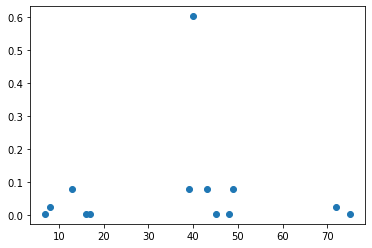

In [125]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [126]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    sigma_e = rot_sigma(0,i,j,phi,theta)@rot_sigma(3,i,j,phi,theta)
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    sigma_o = rot_sigma(1,i,j,phi,theta)@rot_sigma(2,i,j,phi,theta)
    return(sigma_o)



def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    sigma_e = sigma(0,i,j,phi) + sigma(3,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    sigma_o = sigma(1,i,j,phi) + sigma(2,i,j,phi)
    return sigma_o


In [127]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full

In [128]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
    
    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full




In [129]:
%time exp_gate_der(0,np.pi/3)

CPU times: user 9.74 ms, sys: 87 µs, total: 9.83 ms
Wall time: 7.88 ms


<81x81 sparse matrix of type '<class 'numpy.complex128'>'
	with 108 stored elements in COOrdinate format>

In [130]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [131]:
def R(i,theta):
    
    if i%15 == 0:
        return(exp_gate(0,theta))

    if i%15 == 1:
        return(exp_gate(1,theta))

    if i%15 == 2:
        return(exp_gate(2,theta))


    if i%15 == 3:
        return(rot_sigma(0,0,1,0,theta))


    if i%15 == 4:
        return(rot_sigma(0,0,2,0,theta))

    
    if i%15 == 5:
        return(rot_sigma(0,1,2,np.pi/2,theta))

    
    if i%15 == 6:
        return(rot_sigma(1,0,1,0,theta))


    if i%15 == 7:
        return(rot_sigma(1,0,2,0,theta))

    
    if i%15 == 8:
        return(rot_sigma(1,1,2,np.pi/2,theta))

    if i%15 == 9:
        return(rot_sigma(2,0,1,0,theta))


    if i%15 == 10:
        return(rot_sigma(2,0,2,0,theta))

    
    if i%15 == 11:
        return(rot_sigma(2,1,2,np.pi/2,theta))

    
    if i%15 == 12:
        return(rot_sigma(3,0,1,0,theta))


    if i%15 == 13:
        return(rot_sigma(3,0,2,0,theta))

    
    if i%15 == 14:
        return(rot_sigma(3,1,2,np.pi/2,theta))
        

def S(i,theta):
    
    if i%15 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%15 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%15 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())


    if i%15 == 3:
        return(-1j*sigma(0,0,1,0))

    
    if i%15 == 4:
        return(-1j*sigma(0,0,2,0))

    
    if i%15 == 5:
        return(-1j*sigma(0,1,2,np.pi/2))
     
    if i%15 == 6:
        return(-1j*sigma(1,0,1,0))

    
    if i%15 == 7:
        return(-1j*sigma(1,0,2,0))

    
    if i%15 == 8:
        return(-1j*sigma(1,1,2,np.pi/2))

     
    if i%15 == 9:
        return(-1j*sigma(2,0,1,0))

    
    if i%15 == 10:
        return(-1j*sigma(2,0,2,0))
    

    if i%15 == 11:
        return(-1j*sigma(2,1,2,np.pi/2))
    
     
    if i%15 == 12:
        return(-1j*sigma(3,0,1,0))

    
    if i%15 == 13:
        return(-1j*sigma(3,0,2,0))
    

    if i%15 == 14:
        return(-1j*sigma(3,1,2,np.pi/2))

In [132]:
coeff = 15
stepp = 125
t_final = 25

In [133]:
expt_value = []
energyy = []

time_domain = np.linspace(0, t_final, stepp)

Y = []

In [134]:
for kkk in range(3):
    
    N=kkk+1
    start_point = np.random.rand(coeff*N)

    matr = full_ham_matrix.toarray()
    B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
    psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s2 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

    def rhs(t,theta):

        print(datetime.datetime.now())
        for k in range(coeff*N):
            B[k] = R(k,theta[k])

        psi_b = psi_0
        for k in range(coeff*N):
            psi_b = B[coeff*N-1-k]@psi_b

        for i in range(LL+1):
            psi_b = (Proj[i]+Proj_0[i])@psi_b
        norm_b = np.sqrt(np.real(np.conj(psi_b)@psi_b))
        psi_b = psi_b/norm_b



        psi_conj_b = np.conj(psi_b)

        print("start",datetime.datetime.now())

        for k in range(coeff*N):
            B[k] = S(k,theta[k])@R(k,theta[k])
            psi_d[k] = psi_0
            for i in range(coeff*N):
                psi_d[k] = B[coeff*N-1-i]@psi_d[k]
            B[k] = R(k,theta[k])

        print("stop_reduce",datetime.datetime.now())

        psi_conj_d = np.conj(psi_d)


        for k in range(coeff*N):
            for i in range(LL+1):
                psi_d_1[k] = (Proj[i]+Proj_0[i])@psi_d[k]  
            psi_d_s1[k] = psi_d_1[k]/norm_b
            psi_d_s2[k] = -psi_b*(psi_conj_d[k]@psi_b+psi_conj_b@psi_d[k])
            psi_d[k] = psi_d_s1[k]+psi_d_s2[k]

        psi_conj_d = np.conj(psi_d)




        X = np.zeros((coeff*N,coeff*N),dtype = complex)
        Y = np.zeros(coeff*N,dtype = complex)


        X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

        Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)

        XX = np.einsum("il,l->i",psi_conj_d,psi_b)

        YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)

        YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
        YY = YY_1*YY_2
        XX = np.outer(XX,XX)
        X_r = 2*np.real(X+XX)
        Y_i = 2*np.real(Y+YY)
        result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
        print(datetime.datetime.now())

        print(t)

        return result

    # RK-4 method
    def rk4(x0,y0,xn,n):
        global Y

        # Calculating step size
        h = (xn-x0)/n

        #print('\n--------SOLUTION--------')
        #print('-------------------------')    
        #print('x0\ty0\tyn')
        #print('-------------------------')
        for i in range(n):
            k1 = h * (rhs(x0, y0))
            k2 = h * (rhs((x0+h/2), (y0+k1/2)))
            k3 = h * (rhs((x0+h/2), (y0+k2/2)))
            k4 = h * (rhs((x0+h), (y0+k3)))
            k = (k1+2*k2+2*k3+k4)/6
            yn = y0 + k
            #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
            #print('-------------------------')
            y0 = yn
            x0 = x0+h
            Y.append(y0)

        #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

    # Inputs
    #print('Enter initial conditions:')
    #x0 = float(input('x0 = '))
    #y0 = float(input('y0 = '))

    #print('Enter calculation point: ')
    #xn = float(input('xn = '))

    #print('Enter number of steps:')
    #step = int(input('Number of steps = '))

    # RK4 method call
    #start_point = 0.001*np.ones(coeff*N)




    Y = []
    #start_point = np.zeros(coeff*N)

    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])


        psi_var = var_ansatz(theta,psi_0)
        for i in range(LL+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-16 18:32:56.408356
start 2022-08-16 18:32:56.453050
stop_reduce 2022-08-16 18:32:56.553055
2022-08-16 18:32:56.558106
0
2022-08-16 18:32:56.558144
start 2022-08-16 18:32:56.596950
stop_reduce 2022-08-16 18:32:56.700392
2022-08-16 18:32:56.705304
0.1
2022-08-16 18:32:56.705365
start 2022-08-16 18:32:56.743565
stop_reduce 2022-08-16 18:32:56.842378
2022-08-16 18:32:56.847028
0.1
2022-08-16 18:32:56.847072
start 2022-08-16 18:32:56.885138
stop_reduce 2022-08-16 18:32:56.987419
2022-08-16 18:32:56.992392
0.2
2022-08-16 18:32:56.992537
start 2022-08-16 18:32:57.030530
stop_reduce 2022-08-16 18:32:57.129843
2022-08-16 18:32:57.134521
0.2
2022-08-16 18:32:57.134564
start 2022-08-16 18:32:57.172848
stop_reduce 2022-08-16 18:32:57.275108
2022-08-16 18:32:57.280016
0.30000000000000004
2022-08-16 18:32:57.280080
start 2022-08-16 18:32:57.318283
stop_reduce 2022-08-16 18:32:57.419003
2022-08-16 18:32:57.424438
0.30000000000000004
2022-08-16 18:32:57.424493
start 2022-08-16 18:32:57.466076


stop_reduce 2022-08-16 18:33:05.621282
2022-08-16 18:33:05.626217
3.1000000000000005
2022-08-16 18:33:05.626283
start 2022-08-16 18:33:05.664221
stop_reduce 2022-08-16 18:33:05.763627
2022-08-16 18:33:05.768391
3.1000000000000005
2022-08-16 18:33:05.768438
start 2022-08-16 18:33:05.806212
stop_reduce 2022-08-16 18:33:05.908115
2022-08-16 18:33:05.912900
3.2000000000000006
2022-08-16 18:33:05.912949
start 2022-08-16 18:33:05.950785
stop_reduce 2022-08-16 18:33:06.048697
2022-08-16 18:33:06.053248
3.2000000000000006
2022-08-16 18:33:06.053282
start 2022-08-16 18:33:06.091432
stop_reduce 2022-08-16 18:33:06.192348
2022-08-16 18:33:06.197329
3.3000000000000007
2022-08-16 18:33:06.197368
start 2022-08-16 18:33:06.235242
stop_reduce 2022-08-16 18:33:06.333011
2022-08-16 18:33:06.337620
3.3000000000000007
2022-08-16 18:33:06.337654
start 2022-08-16 18:33:06.375494
stop_reduce 2022-08-16 18:33:06.476320
2022-08-16 18:33:06.481031
3.400000000000001
2022-08-16 18:33:06.481073
start 2022-08-16 18

stop_reduce 2022-08-16 18:33:14.329069
2022-08-16 18:33:14.334774
6.000000000000003
2022-08-16 18:33:14.334853
start 2022-08-16 18:33:14.379392
stop_reduce 2022-08-16 18:33:14.481855
2022-08-16 18:33:14.486647
6.000000000000003
2022-08-16 18:33:14.486693
start 2022-08-16 18:33:14.524900
stop_reduce 2022-08-16 18:33:14.639386
2022-08-16 18:33:14.644870
6.100000000000002
2022-08-16 18:33:14.644935
start 2022-08-16 18:33:14.689914
stop_reduce 2022-08-16 18:33:14.793330
2022-08-16 18:33:14.798718
6.100000000000002
2022-08-16 18:33:14.798777
start 2022-08-16 18:33:14.837166
stop_reduce 2022-08-16 18:33:14.942918
2022-08-16 18:33:14.948618
6.200000000000003
2022-08-16 18:33:14.948703
start 2022-08-16 18:33:14.992861
stop_reduce 2022-08-16 18:33:15.110700
2022-08-16 18:33:15.115660
6.200000000000003
2022-08-16 18:33:15.115718
start 2022-08-16 18:33:15.161018
stop_reduce 2022-08-16 18:33:15.264645
2022-08-16 18:33:15.269735
6.3000000000000025
2022-08-16 18:33:15.269792
start 2022-08-16 18:33:1

stop_reduce 2022-08-16 18:33:23.042658
2022-08-16 18:33:23.047688
8.8
2022-08-16 18:33:23.047749
start 2022-08-16 18:33:23.085744
stop_reduce 2022-08-16 18:33:23.183603
2022-08-16 18:33:23.188268
8.9
2022-08-16 18:33:23.188315
start 2022-08-16 18:33:23.225982
stop_reduce 2022-08-16 18:33:23.326698
2022-08-16 18:33:23.331667
8.9
2022-08-16 18:33:23.331725
start 2022-08-16 18:33:23.369497
stop_reduce 2022-08-16 18:33:23.467755
2022-08-16 18:33:23.472330
9.0
2022-08-16 18:33:23.472369
start 2022-08-16 18:33:23.509976
stop_reduce 2022-08-16 18:33:23.610119
2022-08-16 18:33:23.615035
9.0
2022-08-16 18:33:23.615091
start 2022-08-16 18:33:23.652700
stop_reduce 2022-08-16 18:33:23.750282
2022-08-16 18:33:23.754932
9.1
2022-08-16 18:33:23.754977
start 2022-08-16 18:33:23.792520
stop_reduce 2022-08-16 18:33:23.892602
2022-08-16 18:33:23.897329
9.1
2022-08-16 18:33:23.897368
start 2022-08-16 18:33:23.936095
stop_reduce 2022-08-16 18:33:24.033687
2022-08-16 18:33:24.038353
9.2
2022-08-16 18:33:24.

stop_reduce 2022-08-16 18:33:31.268873
2022-08-16 18:33:31.273812
11.69999999999999
2022-08-16 18:33:31.273873
start 2022-08-16 18:33:31.311607
stop_reduce 2022-08-16 18:33:31.409307
2022-08-16 18:33:31.414103
11.79999999999999
2022-08-16 18:33:31.414153
start 2022-08-16 18:33:31.452177
stop_reduce 2022-08-16 18:33:31.552432
2022-08-16 18:33:31.557738
11.79999999999999
2022-08-16 18:33:31.557804
start 2022-08-16 18:33:31.595406
stop_reduce 2022-08-16 18:33:31.692809
2022-08-16 18:33:31.697485
11.89999999999999
2022-08-16 18:33:31.697530
start 2022-08-16 18:33:31.735187
stop_reduce 2022-08-16 18:33:31.834865
2022-08-16 18:33:31.839726
11.89999999999999
2022-08-16 18:33:31.839791
start 2022-08-16 18:33:31.877383
stop_reduce 2022-08-16 18:33:31.975287
2022-08-16 18:33:31.979927
11.99999999999999
2022-08-16 18:33:31.979978
start 2022-08-16 18:33:32.017745
stop_reduce 2022-08-16 18:33:32.119476
2022-08-16 18:33:32.124366
11.99999999999999
2022-08-16 18:33:32.124431
start 2022-08-16 18:33:32

stop_reduce 2022-08-16 18:33:39.534913
2022-08-16 18:33:39.539832
14.59999999999998
2022-08-16 18:33:39.539899
start 2022-08-16 18:33:39.577735
stop_reduce 2022-08-16 18:33:39.675765
2022-08-16 18:33:39.680351
14.69999999999998
2022-08-16 18:33:39.680385
start 2022-08-16 18:33:39.718728
stop_reduce 2022-08-16 18:33:39.825314
2022-08-16 18:33:39.830493
14.69999999999998
2022-08-16 18:33:39.830562
start 2022-08-16 18:33:39.870838
stop_reduce 2022-08-16 18:33:39.974656
2022-08-16 18:33:39.979628
14.79999999999998
2022-08-16 18:33:39.979703
start 2022-08-16 18:33:40.019742
stop_reduce 2022-08-16 18:33:40.133219
2022-08-16 18:33:40.138441
14.79999999999998
2022-08-16 18:33:40.138507
start 2022-08-16 18:33:40.178624
stop_reduce 2022-08-16 18:33:40.282255
2022-08-16 18:33:40.287151
14.899999999999979
2022-08-16 18:33:40.287195
start 2022-08-16 18:33:40.327428
stop_reduce 2022-08-16 18:33:40.435174
2022-08-16 18:33:40.440223
14.899999999999979
2022-08-16 18:33:40.440265
start 2022-08-16 18:33:

stop_reduce 2022-08-16 18:33:47.890021
2022-08-16 18:33:47.894868
17.49999999999997
2022-08-16 18:33:47.894933
start 2022-08-16 18:33:47.932813
stop_reduce 2022-08-16 18:33:48.030791
2022-08-16 18:33:48.035335
17.59999999999997
2022-08-16 18:33:48.035376
start 2022-08-16 18:33:48.073154
stop_reduce 2022-08-16 18:33:48.174748
2022-08-16 18:33:48.179710
17.59999999999997
2022-08-16 18:33:48.179763
start 2022-08-16 18:33:48.217683
stop_reduce 2022-08-16 18:33:48.317064
2022-08-16 18:33:48.321797
17.69999999999997
2022-08-16 18:33:48.321843
start 2022-08-16 18:33:48.359546
stop_reduce 2022-08-16 18:33:48.461616
2022-08-16 18:33:48.466541
17.69999999999997
2022-08-16 18:33:48.466603
start 2022-08-16 18:33:48.504302
stop_reduce 2022-08-16 18:33:48.602537
2022-08-16 18:33:48.607238
17.79999999999997
2022-08-16 18:33:48.607287
start 2022-08-16 18:33:48.645193
stop_reduce 2022-08-16 18:33:48.746550
2022-08-16 18:33:48.751421
17.79999999999997
2022-08-16 18:33:48.751490
start 2022-08-16 18:33:48

stop_reduce 2022-08-16 18:33:56.162971
2022-08-16 18:33:56.167875
20.39999999999996
2022-08-16 18:33:56.167916
start 2022-08-16 18:33:56.205718
stop_reduce 2022-08-16 18:33:56.304737
2022-08-16 18:33:56.309388
20.49999999999996
2022-08-16 18:33:56.309436
start 2022-08-16 18:33:56.347532
stop_reduce 2022-08-16 18:33:56.448902
2022-08-16 18:33:56.453735
20.49999999999996
2022-08-16 18:33:56.453780
start 2022-08-16 18:33:56.491672
stop_reduce 2022-08-16 18:33:56.589331
2022-08-16 18:33:56.594391
20.59999999999996
2022-08-16 18:33:56.594442
start 2022-08-16 18:33:56.633570
stop_reduce 2022-08-16 18:33:56.735045
2022-08-16 18:33:56.739903
20.59999999999996
2022-08-16 18:33:56.739951
start 2022-08-16 18:33:56.777897
stop_reduce 2022-08-16 18:33:56.875772
2022-08-16 18:33:56.880412
20.69999999999996
2022-08-16 18:33:56.880458
start 2022-08-16 18:33:56.918378
stop_reduce 2022-08-16 18:33:57.020151
2022-08-16 18:33:57.024940
20.69999999999996
2022-08-16 18:33:57.024984
start 2022-08-16 18:33:57

stop_reduce 2022-08-16 18:34:04.452267
2022-08-16 18:34:04.457072
23.29999999999995
2022-08-16 18:34:04.457115
start 2022-08-16 18:34:04.495015
stop_reduce 2022-08-16 18:34:04.593009
2022-08-16 18:34:04.597575
23.39999999999995
2022-08-16 18:34:04.597614
start 2022-08-16 18:34:04.635439
stop_reduce 2022-08-16 18:34:04.736930
2022-08-16 18:34:04.741777
23.39999999999995
2022-08-16 18:34:04.741848
start 2022-08-16 18:34:04.779668
stop_reduce 2022-08-16 18:34:04.877600
2022-08-16 18:34:04.882291
23.49999999999995
2022-08-16 18:34:04.882338
start 2022-08-16 18:34:04.920002
stop_reduce 2022-08-16 18:34:05.021819
2022-08-16 18:34:05.026732
23.49999999999995
2022-08-16 18:34:05.026788
start 2022-08-16 18:34:05.064838
stop_reduce 2022-08-16 18:34:05.163295
2022-08-16 18:34:05.167945
23.599999999999948
2022-08-16 18:34:05.167993
start 2022-08-16 18:34:05.205761
stop_reduce 2022-08-16 18:34:05.306714
2022-08-16 18:34:05.311570
23.599999999999948
2022-08-16 18:34:05.311637
start 2022-08-16 18:34:

stop_reduce 2022-08-16 18:34:21.367298
2022-08-16 18:34:21.376382
1.3
2022-08-16 18:34:21.376437
start 2022-08-16 18:34:21.451256
stop_reduce 2022-08-16 18:34:21.652820
2022-08-16 18:34:21.662129
1.3
2022-08-16 18:34:21.662195
start 2022-08-16 18:34:21.737348
stop_reduce 2022-08-16 18:34:21.938371
2022-08-16 18:34:21.947483
1.4
2022-08-16 18:34:21.947538
start 2022-08-16 18:34:22.021848
stop_reduce 2022-08-16 18:34:22.222159
2022-08-16 18:34:22.231491
1.4
2022-08-16 18:34:22.231629
start 2022-08-16 18:34:22.306041
stop_reduce 2022-08-16 18:34:22.507067
2022-08-16 18:34:22.516302
1.5
2022-08-16 18:34:22.516349
start 2022-08-16 18:34:22.591056
stop_reduce 2022-08-16 18:34:22.790813
2022-08-16 18:34:22.800137
1.5
2022-08-16 18:34:22.800205
start 2022-08-16 18:34:22.874942
stop_reduce 2022-08-16 18:34:23.075297
2022-08-16 18:34:23.084421
1.5999999999999999
2022-08-16 18:34:23.084472
start 2022-08-16 18:34:23.159111
stop_reduce 2022-08-16 18:34:23.360532
2022-08-16 18:34:23.369789
1.5999999

stop_reduce 2022-08-16 18:34:38.271083
2022-08-16 18:34:38.280499
4.200000000000001
2022-08-16 18:34:38.280566
start 2022-08-16 18:34:38.356917
stop_reduce 2022-08-16 18:34:38.559845
2022-08-16 18:34:38.568908
4.300000000000001
2022-08-16 18:34:38.568958
start 2022-08-16 18:34:38.645128
stop_reduce 2022-08-16 18:34:38.847183
2022-08-16 18:34:38.856210
4.300000000000001
2022-08-16 18:34:38.856257
start 2022-08-16 18:34:38.933018
stop_reduce 2022-08-16 18:34:39.135865
2022-08-16 18:34:39.145253
4.400000000000001
2022-08-16 18:34:39.145318
start 2022-08-16 18:34:39.221567
stop_reduce 2022-08-16 18:34:39.424440
2022-08-16 18:34:39.433885
4.400000000000001
2022-08-16 18:34:39.433949
start 2022-08-16 18:34:39.510478
stop_reduce 2022-08-16 18:34:39.712648
2022-08-16 18:34:39.722043
4.500000000000001
2022-08-16 18:34:39.722111
start 2022-08-16 18:34:39.798070
stop_reduce 2022-08-16 18:34:40.001937
2022-08-16 18:34:40.011007
4.500000000000001
2022-08-16 18:34:40.011056
start 2022-08-16 18:34:40

stop_reduce 2022-08-16 18:34:54.798318
2022-08-16 18:34:54.807381
7.100000000000003
2022-08-16 18:34:54.807568
start 2022-08-16 18:34:54.883845
stop_reduce 2022-08-16 18:34:55.087254
2022-08-16 18:34:55.096312
7.100000000000003
2022-08-16 18:34:55.096374
start 2022-08-16 18:34:55.174071
stop_reduce 2022-08-16 18:34:55.377673
2022-08-16 18:34:55.386727
7.200000000000004
2022-08-16 18:34:55.386916
start 2022-08-16 18:34:55.463405
stop_reduce 2022-08-16 18:34:55.666874
2022-08-16 18:34:55.675993
7.200000000000004
2022-08-16 18:34:55.676063
start 2022-08-16 18:34:55.752965
stop_reduce 2022-08-16 18:34:55.956481
2022-08-16 18:34:55.965578
7.300000000000003
2022-08-16 18:34:55.965645
start 2022-08-16 18:34:56.042473
stop_reduce 2022-08-16 18:34:56.246218
2022-08-16 18:34:56.255291
7.300000000000003
2022-08-16 18:34:56.255467
start 2022-08-16 18:34:56.332161
stop_reduce 2022-08-16 18:34:56.536963
2022-08-16 18:34:56.546064
7.400000000000004
2022-08-16 18:34:56.546249
start 2022-08-16 18:34:56

stop_reduce 2022-08-16 18:35:11.688074
2022-08-16 18:35:11.697120
9.999999999999996
2022-08-16 18:35:11.697198
start 2022-08-16 18:35:11.773939
stop_reduce 2022-08-16 18:35:11.977613
2022-08-16 18:35:11.986713
9.999999999999996
2022-08-16 18:35:11.986777
start 2022-08-16 18:35:12.063785
stop_reduce 2022-08-16 18:35:12.267774
2022-08-16 18:35:12.276884
10.099999999999996
2022-08-16 18:35:12.277069
start 2022-08-16 18:35:12.354352
stop_reduce 2022-08-16 18:35:12.559577
2022-08-16 18:35:12.568622
10.099999999999996
2022-08-16 18:35:12.568697
start 2022-08-16 18:35:12.645862
stop_reduce 2022-08-16 18:35:12.849218
2022-08-16 18:35:12.858344
10.199999999999996
2022-08-16 18:35:12.858531
start 2022-08-16 18:35:12.937294
stop_reduce 2022-08-16 18:35:13.140645
2022-08-16 18:35:13.149719
10.199999999999996
2022-08-16 18:35:13.149787
start 2022-08-16 18:35:13.227387
stop_reduce 2022-08-16 18:35:13.433213
2022-08-16 18:35:13.442308
10.299999999999995
2022-08-16 18:35:13.442376
start 2022-08-16 18:

stop_reduce 2022-08-16 18:35:28.315785
2022-08-16 18:35:28.325192
12.799999999999986
2022-08-16 18:35:28.325265
start 2022-08-16 18:35:28.402677
stop_reduce 2022-08-16 18:35:28.609560
2022-08-16 18:35:28.618892
12.899999999999986
2022-08-16 18:35:28.618944
start 2022-08-16 18:35:28.696609
stop_reduce 2022-08-16 18:35:28.901675
2022-08-16 18:35:28.911071
12.899999999999986
2022-08-16 18:35:28.911127
start 2022-08-16 18:35:28.988654
stop_reduce 2022-08-16 18:35:29.194056
2022-08-16 18:35:29.203328
12.999999999999986
2022-08-16 18:35:29.203381
start 2022-08-16 18:35:29.281103
stop_reduce 2022-08-16 18:35:29.486476
2022-08-16 18:35:29.495639
12.999999999999986
2022-08-16 18:35:29.495690
start 2022-08-16 18:35:29.573240
stop_reduce 2022-08-16 18:35:29.778878
2022-08-16 18:35:29.788081
13.099999999999985
2022-08-16 18:35:29.788131
start 2022-08-16 18:35:29.865625
stop_reduce 2022-08-16 18:35:30.070636
2022-08-16 18:35:30.079912
13.099999999999985
2022-08-16 18:35:30.079961
start 2022-08-16 1

stop_reduce 2022-08-16 18:35:44.963505
2022-08-16 18:35:44.972624
15.699999999999976
2022-08-16 18:35:44.972678
start 2022-08-16 18:35:45.049874
stop_reduce 2022-08-16 18:35:45.255665
2022-08-16 18:35:45.265106
15.699999999999976
2022-08-16 18:35:45.265168
start 2022-08-16 18:35:45.342217
stop_reduce 2022-08-16 18:35:45.546702
2022-08-16 18:35:45.556087
15.799999999999976
2022-08-16 18:35:45.556153
start 2022-08-16 18:35:45.633253
stop_reduce 2022-08-16 18:35:45.837194
2022-08-16 18:35:45.846636
15.799999999999976
2022-08-16 18:35:45.846706
start 2022-08-16 18:35:45.924594
stop_reduce 2022-08-16 18:35:46.128544
2022-08-16 18:35:46.137904
15.899999999999975
2022-08-16 18:35:46.137965
start 2022-08-16 18:35:46.214756
stop_reduce 2022-08-16 18:35:46.418715
2022-08-16 18:35:46.427846
15.899999999999975
2022-08-16 18:35:46.427891
start 2022-08-16 18:35:46.504746
stop_reduce 2022-08-16 18:35:46.708318
2022-08-16 18:35:46.717810
15.999999999999975
2022-08-16 18:35:46.717878
start 2022-08-16 1

stop_reduce 2022-08-16 18:36:01.562871
2022-08-16 18:36:01.572178
18.499999999999968
2022-08-16 18:36:01.572240
start 2022-08-16 18:36:01.649830
stop_reduce 2022-08-16 18:36:01.854691
2022-08-16 18:36:01.863816
18.599999999999966
2022-08-16 18:36:01.863869
start 2022-08-16 18:36:01.941042
stop_reduce 2022-08-16 18:36:02.146738
2022-08-16 18:36:02.156153
18.599999999999966
2022-08-16 18:36:02.156203
start 2022-08-16 18:36:02.233460
stop_reduce 2022-08-16 18:36:02.437605
2022-08-16 18:36:02.447018
18.699999999999967
2022-08-16 18:36:02.447076
start 2022-08-16 18:36:02.524038
stop_reduce 2022-08-16 18:36:02.727590
2022-08-16 18:36:02.736806
18.699999999999967
2022-08-16 18:36:02.736852
start 2022-08-16 18:36:02.814973
stop_reduce 2022-08-16 18:36:03.019933
2022-08-16 18:36:03.029123
18.799999999999965
2022-08-16 18:36:03.029174
start 2022-08-16 18:36:03.106580
stop_reduce 2022-08-16 18:36:03.314059
2022-08-16 18:36:03.323458
18.799999999999965
2022-08-16 18:36:03.323525
start 2022-08-16 1

stop_reduce 2022-08-16 18:36:19.437609
2022-08-16 18:36:19.447736
21.399999999999956
2022-08-16 18:36:19.447806
start 2022-08-16 18:36:19.532447
stop_reduce 2022-08-16 18:36:19.773526
2022-08-16 18:36:19.783714
21.399999999999956
2022-08-16 18:36:19.783779
start 2022-08-16 18:36:19.867068
stop_reduce 2022-08-16 18:36:20.086843
2022-08-16 18:36:20.096740
21.499999999999957
2022-08-16 18:36:20.096797
start 2022-08-16 18:36:20.180214
stop_reduce 2022-08-16 18:36:20.408664
2022-08-16 18:36:20.419190
21.499999999999957
2022-08-16 18:36:20.419256
start 2022-08-16 18:36:20.503275
stop_reduce 2022-08-16 18:36:20.723288
2022-08-16 18:36:20.733210
21.599999999999955
2022-08-16 18:36:20.733407
start 2022-08-16 18:36:20.816533
stop_reduce 2022-08-16 18:36:21.036657
2022-08-16 18:36:21.046514
21.599999999999955
2022-08-16 18:36:21.046711
start 2022-08-16 18:36:21.129908
stop_reduce 2022-08-16 18:36:21.357114
2022-08-16 18:36:21.367028
21.699999999999957
2022-08-16 18:36:21.367226
start 2022-08-16 1

stop_reduce 2022-08-16 18:36:37.416679
2022-08-16 18:36:37.426772
24.199999999999946
2022-08-16 18:36:37.426840
start 2022-08-16 18:36:37.509959
stop_reduce 2022-08-16 18:36:37.735541
2022-08-16 18:36:37.745617
24.299999999999947
2022-08-16 18:36:37.745692
start 2022-08-16 18:36:37.828884
stop_reduce 2022-08-16 18:36:38.048709
2022-08-16 18:36:38.058828
24.299999999999947
2022-08-16 18:36:38.058892
start 2022-08-16 18:36:38.141962
stop_reduce 2022-08-16 18:36:38.362138
2022-08-16 18:36:38.372073
24.399999999999945
2022-08-16 18:36:38.372130
start 2022-08-16 18:36:38.455282
stop_reduce 2022-08-16 18:36:38.680737
2022-08-16 18:36:38.690816
24.399999999999945
2022-08-16 18:36:38.690881
start 2022-08-16 18:36:38.773996
stop_reduce 2022-08-16 18:36:38.994213
2022-08-16 18:36:39.004300
24.499999999999947
2022-08-16 18:36:39.004366
start 2022-08-16 18:36:39.087589
stop_reduce 2022-08-16 18:36:39.307982
2022-08-16 18:36:39.317826
24.499999999999947
2022-08-16 18:36:39.317873
start 2022-08-16 1

stop_reduce 2022-08-16 18:37:14.365940
2022-08-16 18:37:14.380839
2.1999999999999997
2022-08-16 18:37:14.380913
start 2022-08-16 18:37:14.508196
stop_reduce 2022-08-16 18:37:14.856439
2022-08-16 18:37:14.871276
2.3
2022-08-16 18:37:14.871328
start 2022-08-16 18:37:14.998490
stop_reduce 2022-08-16 18:37:15.334948
2022-08-16 18:37:15.349844
2.3
2022-08-16 18:37:15.349902
start 2022-08-16 18:37:15.476706
stop_reduce 2022-08-16 18:37:15.812956
2022-08-16 18:37:15.827791
2.4
2022-08-16 18:37:15.827855
start 2022-08-16 18:37:15.954778
stop_reduce 2022-08-16 18:37:16.301068
2022-08-16 18:37:16.316219
2.4
2022-08-16 18:37:16.316276
start 2022-08-16 18:37:16.449297
stop_reduce 2022-08-16 18:37:16.823912
2022-08-16 18:37:16.845384
2.5
2022-08-16 18:37:16.845679
start 2022-08-16 18:37:17.020694
stop_reduce 2022-08-16 18:37:17.419856
2022-08-16 18:37:17.435903
2.5
2022-08-16 18:37:17.435960
start 2022-08-16 18:37:17.572855
stop_reduce 2022-08-16 18:37:17.935883
2022-08-16 18:37:17.951860
2.6
2022-

stop_reduce 2022-08-16 18:37:42.490457
2022-08-16 18:37:42.505510
5.100000000000001
2022-08-16 18:37:42.505685
start 2022-08-16 18:37:42.633229
stop_reduce 2022-08-16 18:37:42.970724
2022-08-16 18:37:42.985647
5.200000000000002
2022-08-16 18:37:42.985708
start 2022-08-16 18:37:43.113402
stop_reduce 2022-08-16 18:37:43.450496
2022-08-16 18:37:43.465417
5.200000000000002
2022-08-16 18:37:43.465475
start 2022-08-16 18:37:43.608296
stop_reduce 2022-08-16 18:37:43.942503
2022-08-16 18:37:43.957049
5.300000000000002
2022-08-16 18:37:43.957105
start 2022-08-16 18:37:44.084892
stop_reduce 2022-08-16 18:37:44.420557
2022-08-16 18:37:44.436045
5.300000000000002
2022-08-16 18:37:44.436096
start 2022-08-16 18:37:44.564118
stop_reduce 2022-08-16 18:37:44.902044
2022-08-16 18:37:44.917024
5.400000000000002
2022-08-16 18:37:44.917088
start 2022-08-16 18:37:45.044966
stop_reduce 2022-08-16 18:37:45.380802
2022-08-16 18:37:45.395450
5.400000000000002
2022-08-16 18:37:45.395502
start 2022-08-16 18:37:45

stop_reduce 2022-08-16 18:38:10.039086
2022-08-16 18:38:10.053703
8.000000000000004
2022-08-16 18:38:10.053930
start 2022-08-16 18:38:10.181975
stop_reduce 2022-08-16 18:38:10.518689
2022-08-16 18:38:10.533712
8.000000000000004
2022-08-16 18:38:10.533908
start 2022-08-16 18:38:10.661992
stop_reduce 2022-08-16 18:38:10.998358
2022-08-16 18:38:11.013017
8.100000000000003
2022-08-16 18:38:11.013071
start 2022-08-16 18:38:11.141060
stop_reduce 2022-08-16 18:38:11.477901
2022-08-16 18:38:11.492489
8.100000000000003
2022-08-16 18:38:11.492544
start 2022-08-16 18:38:11.620737
stop_reduce 2022-08-16 18:38:11.958982
2022-08-16 18:38:11.974004
8.200000000000003
2022-08-16 18:38:11.974067
start 2022-08-16 18:38:12.101937
stop_reduce 2022-08-16 18:38:12.437195
2022-08-16 18:38:12.452229
8.200000000000003
2022-08-16 18:38:12.452299
start 2022-08-16 18:38:12.580391
stop_reduce 2022-08-16 18:38:12.916692
2022-08-16 18:38:12.931276
8.300000000000002
2022-08-16 18:38:12.931325
start 2022-08-16 18:38:13

stop_reduce 2022-08-16 18:38:38.029719
2022-08-16 18:38:38.044275
10.899999999999993
2022-08-16 18:38:38.044332
start 2022-08-16 18:38:38.171418
stop_reduce 2022-08-16 18:38:38.508747
2022-08-16 18:38:38.523438
10.899999999999993
2022-08-16 18:38:38.523489
start 2022-08-16 18:38:38.650421
stop_reduce 2022-08-16 18:38:38.985756
2022-08-16 18:38:39.000721
10.999999999999993
2022-08-16 18:38:39.000784
start 2022-08-16 18:38:39.127815
stop_reduce 2022-08-16 18:38:39.463568
2022-08-16 18:38:39.478655
10.999999999999993
2022-08-16 18:38:39.478712
start 2022-08-16 18:38:39.605944
stop_reduce 2022-08-16 18:38:39.945191
2022-08-16 18:38:39.960135
11.099999999999993
2022-08-16 18:38:39.960194
start 2022-08-16 18:38:40.087241
stop_reduce 2022-08-16 18:38:40.424311
2022-08-16 18:38:40.439074
11.099999999999993
2022-08-16 18:38:40.439275
start 2022-08-16 18:38:40.566087
stop_reduce 2022-08-16 18:38:40.908897
2022-08-16 18:38:40.923669
11.199999999999992
2022-08-16 18:38:40.923731
start 2022-08-16 1

stop_reduce 2022-08-16 18:39:05.854093
2022-08-16 18:39:05.869003
13.699999999999983
2022-08-16 18:39:05.869050
start 2022-08-16 18:39:05.996538
stop_reduce 2022-08-16 18:39:06.338097
2022-08-16 18:39:06.353496
13.799999999999983
2022-08-16 18:39:06.353560
start 2022-08-16 18:39:06.491658
stop_reduce 2022-08-16 18:39:06.829747
2022-08-16 18:39:06.844727
13.799999999999983
2022-08-16 18:39:06.844784
start 2022-08-16 18:39:06.972201
stop_reduce 2022-08-16 18:39:07.311381
2022-08-16 18:39:07.326405
13.899999999999983
2022-08-16 18:39:07.326462
start 2022-08-16 18:39:07.469795
stop_reduce 2022-08-16 18:39:07.808160
2022-08-16 18:39:07.822874
13.899999999999983
2022-08-16 18:39:07.822927
start 2022-08-16 18:39:07.950502
stop_reduce 2022-08-16 18:39:08.289995
2022-08-16 18:39:08.304564
13.999999999999982
2022-08-16 18:39:08.304639
start 2022-08-16 18:39:08.441598
stop_reduce 2022-08-16 18:39:08.782678
2022-08-16 18:39:08.797276
13.999999999999982
2022-08-16 18:39:08.797333
start 2022-08-16 1

stop_reduce 2022-08-16 18:39:33.812620
2022-08-16 18:39:33.827677
16.599999999999973
2022-08-16 18:39:33.827742
start 2022-08-16 18:39:33.954732
stop_reduce 2022-08-16 18:39:34.294241
2022-08-16 18:39:34.309987
16.599999999999973
2022-08-16 18:39:34.310052
start 2022-08-16 18:39:34.437385
stop_reduce 2022-08-16 18:39:34.784306
2022-08-16 18:39:34.799266
16.699999999999974
2022-08-16 18:39:34.799322
start 2022-08-16 18:39:34.926909
stop_reduce 2022-08-16 18:39:35.268056
2022-08-16 18:39:35.283437
16.699999999999974
2022-08-16 18:39:35.283516
start 2022-08-16 18:39:35.411049
stop_reduce 2022-08-16 18:39:35.758608
2022-08-16 18:39:35.773180
16.799999999999972
2022-08-16 18:39:35.773387
start 2022-08-16 18:39:35.900810
stop_reduce 2022-08-16 18:39:36.239972
2022-08-16 18:39:36.255055
16.799999999999972
2022-08-16 18:39:36.255115
start 2022-08-16 18:39:36.382494
stop_reduce 2022-08-16 18:39:36.722178
2022-08-16 18:39:36.736767
16.899999999999974
2022-08-16 18:39:36.736919
start 2022-08-16 1

stop_reduce 2022-08-16 18:40:01.460041
2022-08-16 18:40:01.474611
19.399999999999963
2022-08-16 18:40:01.474685
start 2022-08-16 18:40:01.602480
stop_reduce 2022-08-16 18:40:01.940405
2022-08-16 18:40:01.955022
19.499999999999964
2022-08-16 18:40:01.955100
start 2022-08-16 18:40:02.082627
stop_reduce 2022-08-16 18:40:02.425321
2022-08-16 18:40:02.441704
19.499999999999964
2022-08-16 18:40:02.441766
start 2022-08-16 18:40:02.569728
stop_reduce 2022-08-16 18:40:02.907709
2022-08-16 18:40:02.922264
19.599999999999962
2022-08-16 18:40:02.922340
start 2022-08-16 18:40:03.050058
stop_reduce 2022-08-16 18:40:03.389009
2022-08-16 18:40:03.403500
19.599999999999962
2022-08-16 18:40:03.403689
start 2022-08-16 18:40:03.531321
stop_reduce 2022-08-16 18:40:03.867418
2022-08-16 18:40:03.882002
19.699999999999964
2022-08-16 18:40:03.882061
start 2022-08-16 18:40:04.009686
stop_reduce 2022-08-16 18:40:04.346920
2022-08-16 18:40:04.361483
19.699999999999964
2022-08-16 18:40:04.361532
start 2022-08-16 1

stop_reduce 2022-08-16 18:40:29.127236
2022-08-16 18:40:29.141729
22.299999999999955
2022-08-16 18:40:29.141925
start 2022-08-16 18:40:29.268973
stop_reduce 2022-08-16 18:40:29.609291
2022-08-16 18:40:29.623900
22.299999999999955
2022-08-16 18:40:29.624205
start 2022-08-16 18:40:29.751267
stop_reduce 2022-08-16 18:40:30.090069
2022-08-16 18:40:30.105058
22.399999999999952
2022-08-16 18:40:30.105121
start 2022-08-16 18:40:30.232312
stop_reduce 2022-08-16 18:40:30.574301
2022-08-16 18:40:30.589412
22.399999999999952
2022-08-16 18:40:30.589471
start 2022-08-16 18:40:30.716853
stop_reduce 2022-08-16 18:40:31.055959
2022-08-16 18:40:31.071031
22.499999999999954
2022-08-16 18:40:31.071087
start 2022-08-16 18:40:31.198418
stop_reduce 2022-08-16 18:40:31.538701
2022-08-16 18:40:31.553545
22.499999999999954
2022-08-16 18:40:31.553609
start 2022-08-16 18:40:31.681000
stop_reduce 2022-08-16 18:40:32.020561
2022-08-16 18:40:32.035174
22.59999999999995
2022-08-16 18:40:32.035395
start 2022-08-16 18

In [135]:
f = open("Imaginary_time_evolution_2d_fidelity: 1plaquette,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(expt_value[0][l])+" "+str(expt_value[1][l])+" "+str(expt_value[2][l])+"\n")
f.close()

In [136]:
f = open("Imaginary_time_evolution_2d_energy: 1plaquette,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(energyy[0][l])+" "+str(energyy[1][l])+" "+str(energyy[2][l])+"\n")
f.close()

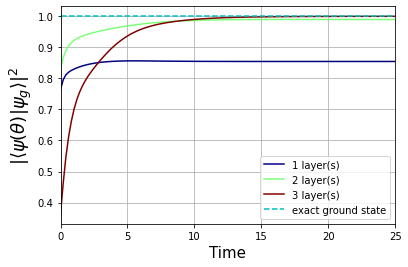

In [145]:
n = 3
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(3):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,25)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_2d_fidelity_over_layers_1Plaquette_M=0.1.pdf")

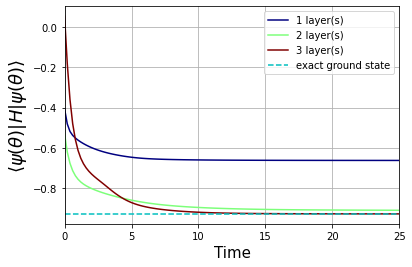

In [146]:
for kkk in range(3):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,25)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_2d_energy_over_layers_1Plaquette_M=0.1.pdf")

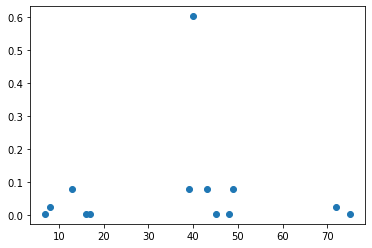

In [140]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvec[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

###### import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

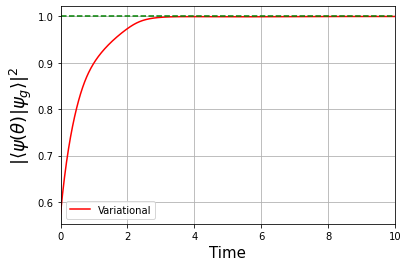

(0.0, 10.0)

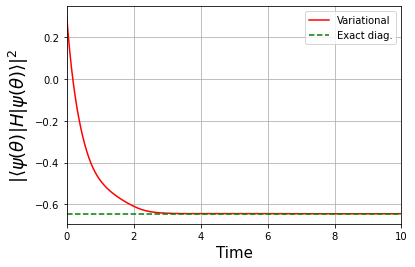

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
